In [2]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sb
from warnings import *
filterwarnings("ignore")
import  tensorflow   as  tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [88]:
train,test,validation= tfds.load("dtd",split=['train[:85%]','train[85%:95%]','validation[95%:]'],batch_size=-1)
print("Done!")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/dtd/3.0.1.incomplete7UXPBF/dtd-train.tfrecord*...:   0%|          | 0/1880…

Generating test examples...:   0%|          | 0/1880 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dtd/3.0.1.incomplete7UXPBF/dtd-test.tfrecord*...:   0%|          | 0/1880 …

Generating validation examples...:   0%|          | 0/1880 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dtd/3.0.1.incomplete7UXPBF/dtd-validation.tfrecord*...:   0%|          | 0…

Dataset dtd downloaded and prepared to /root/tensorflow_datasets/dtd/3.0.1. Subsequent calls will reuse this data.
Done!


In [ ]:
print(f"Shape : {train['image'].shape} images ;\n\n Train : {len(train['image'])} images  ;\n\n Test : {len(test['image'])} images ;\n\n Label : 1000 classes ; ")

Shape : (1598, 701, 800, 3) images ;

 Train : 1598 images  ;

 Test : 188 images ;

 Label : 1000 classes ; 


In [89]:
datas = tfds.builder('dtd')
info = datas.info
print(info)

tfds.core.DatasetInfo(
    name='dtd',
    full_name='dtd/3.0.1',
    description="""
    The Describable Textures Dataset (DTD) is an evolving collection of textural
    images in the wild, annotated with a series of human-centric attributes,
    inspired by the perceptual properties of textures. This data is made available
    to the computer vision community for research purposes.
    
    The "label" of each example is its "key attribute" (see the official website).
    The official release of the dataset defines a 10-fold cross-validation
    partition. Our TRAIN/TEST/VALIDATION splits are those of the first fold.
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/dtd/index.html',
    data_path='/root/tensorflow_datasets/dtd/3.0.1',
    file_format=tfrecord,
    download_size=596.28 MiB,
    dataset_size=603.00 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': C

In [90]:
num_classes = info.features['label'].num_classes
labels = []
for i in range(num_classes):
    labels.append(info.features['label'].int2str(i))
len(labels)

47

In [91]:
train_data,train_label = tfds.as_numpy(train['image']),tfds.as_numpy(train['label'])
test_data,test_label = tfds.as_numpy(test['image']),tfds.as_numpy(test['label'])
validation_data,validation_label = tfds.as_numpy(validation['image']),tfds.as_numpy(validation['label'])

In [92]:
def resizing(images):
    im_data = []
    for image in images:
      img = cv2.resize(image,(224,224),interpolation=cv2.INTER_AREA)
      im_data.append(img)
    return im_data
def preprocess(imgs,labs):
    imgs = np.array(imgs)
    imgs = imgs/255.0
    imgs = imgs.astype('float32')
    labs = np.array(labs)
    label = labs.astype("uint32")
    return imgs,label

In [93]:
x_train = resizing(train_data)
x_test = resizing(test_data)
x_train,y_train = preprocess(x_train,train_label)
x_test,y_test = preprocess(x_test,test_label)

In [94]:
x_val = resizing(validation_data)
x_valid,y_valid = preprocess(x_val,validation_label)

In [95]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,y_valid)).batch(32)

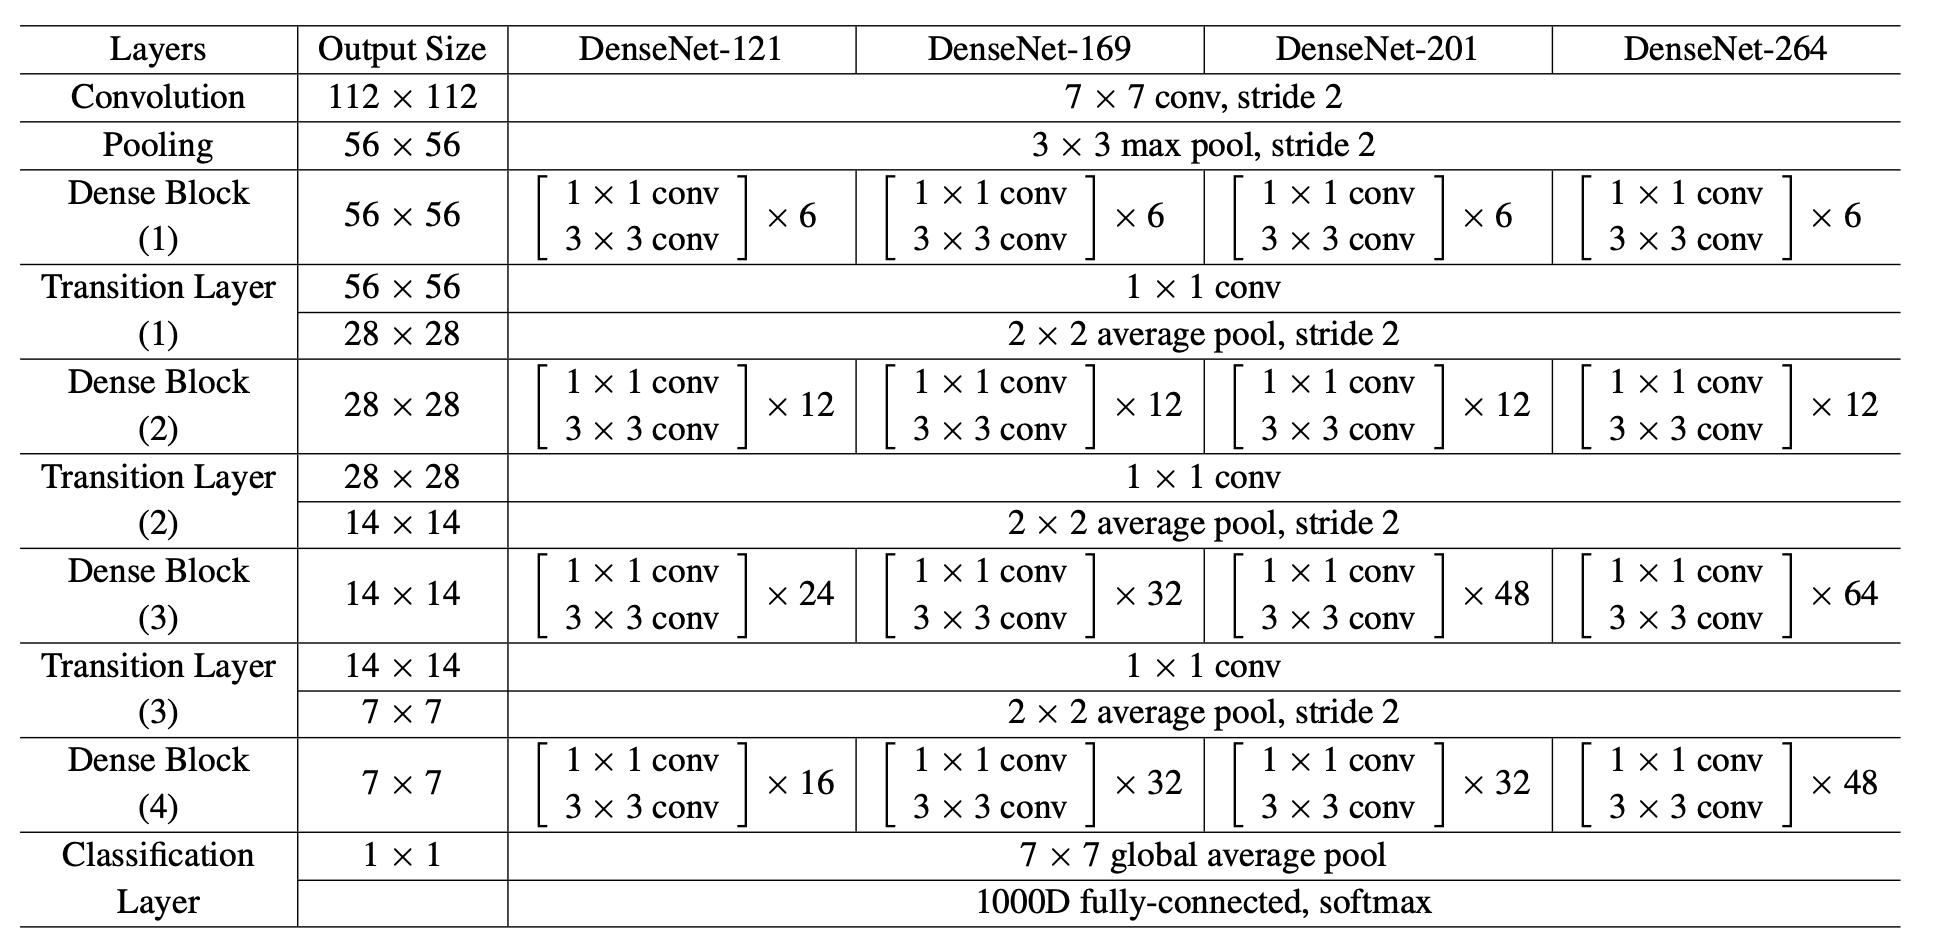

In [74]:
def transition_layer(x,fltr,dropout_,stage2,block2):
        c_name= "convstage_"+str(stage2)+"brach_"+block2
        b_name="batchstage_"+str(stage2)+"brach_"+block2
        x = tf.keras.layers.BatchNormalization(axis=3,name = b_name)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2D(int(fltr),kernel_size=(1, 1),strides=2,kernel_regularizer='l1',name=c_name)(x)
        print(x.shape)
        if dropout_:
           x = x=tf.keras.layers.Dropout(dropout_)(x)
        x =tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=2)(x)
        return x

In [76]:
def dense_layer(x1,dropout1,stage1,block1,k1):
            c_name= "convstage_"+str(stage1)+"brach_"+str(block1)
            b_name="batchstage_"+str(stage1)+"brach_"+str(block1)
            #layer1x1
            num_filt=k1*4
            x = tf.keras.layers.BatchNormalization()(x1)
            x= tf.keras.layers.Activation("relu")(x)
            x = tf.keras.layers.Conv2D(int(num_filt),kernel_size=(1, 1),padding='same',kernel_regularizer='l2',name=c_name+'_1x1')(x)
            if dropout1:
              x=tf.keras.layers.Dropout(dropout1)(x)
            #layer3x3
            x = tf.keras.layers.BatchNormalization()(x)
            relu_2= tf.keras.layers.Activation("relu")(x)
            x = tf.keras.layers.Conv2D(filters=k1, kernel_size=(3,3), padding='same', kernel_regularizer='l2',name=c_name+'_3x3')(relu_2)
            print(x.shape)
            if dropout1:
              x=tf.keras.layers.Dropout(dropout1)(x)

            return x

In [77]:
def dense_block(x,k,dropouts,stage,num_cycle,growth_rate,inc_num_filters=True):
        # to concatenate all blocks
        x_shortcut = x
        # layer function
        for i in range(num_cycle):
            blocks=i+1
            x=dense_layer(x_shortcut,dropouts,stage,blocks,growth_rate)
            x_shortcut = tf.keras.layers.Concatenate(axis=-1)([x_shortcut,x])
            if inc_num_filters:
              k+=growth_rate
        print(x_shortcut.shape)
        return x_shortcut,k

In [84]:
class DenseNet(tf.keras.Model):
    def __init__(self, input_shape, classes,dropoutf=0.0):
        super(DenseNet, self).__init__(name='DenseNet_121')
        #input_variables
        self.classes = classes
        self.n_filters = 64
        # Stage 1
        self.inputs_1= tf.keras.layers.Input(shape=input_shape)
        print((None,224,224,3))
        X = tf.keras.layers.Conv2D(self.n_filters,kernel_size=(7, 7),strides=2,kernel_regularizer='l1')(self.inputs_1)
        print(X.shape)
        X = tf.keras.layers.BatchNormalization(axis=int(3))(X)
        X = tf.keras.layers.Activation("relu")(X)
        X =tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2)(X)
        print(X.shape)
        # According to my model it passes through 4 Dense block and 3 Transition layers

        # Dense block(1)
        X,no_filter = dense_block(X,self.n_filters,dropoutf,stage=2,num_cycle=6,growth_rate=32)
        # Transition layer(1)
        X = transition_layer(X,self.n_filters,dropoutf,stage2=2,block2='A')
        self.filters1 = int(no_filter)


        # Dense block(2)
        X,no_filter = dense_block(X,self.filters1,dropoutf,stage=3,num_cycle=12,growth_rate=32)
        # Transition layer(2)
        X = transition_layer(X,self.filters1,dropoutf,stage2=3,block2='B')
        self.filters2 = int(no_filter)

        # Dense block(3)
        X,no_filter = dense_block(X,self.filters2,dropoutf,stage=4,num_cycle=24,growth_rate=32)
        # Transition layer(3)
        X = transition_layer(X,self.filters2,dropoutf,stage2=4,block2='C')
        self.filters3 = int(no_filter)

        # Dense block(4)
        X,no_filter = dense_block(X,self.filters3,dropoutf,stage=5,num_cycle=16,growth_rate=32)

        # Batch
        X = tf.keras.layers.BatchNormalization(axis=3)(X)
        #Activation
        X = tf.keras.layers.Activation("relu")(X)
        print(X.shape)
        #Pooling
        gl_avr = tf.keras.layers.GlobalAveragePooling2D()(X)
        print(gl_avr.shape)
        #Flatten
        flat = tf.keras.layers.Flatten()(gl_avr)
        #Fully-Connected layer

        Dense_layer = tf.keras.layers.Dense(self.classes)(flat)
        print(Dense_layer.shape)
        # Activation
        output_layer = tf.keras.layers.Activation("softmax")(Dense_layer)

        self.outputs = tf.keras.Model(inputs=self.inputs_1, outputs=output_layer)
    def call(self, x):
        return self.outputs(x)

In [85]:
Classes=47
input_size=(224,224,3)
densenet_model = DenseNet(input_shape=input_size,classes=Classes)

(None, 224, 224, 3)
(None, 109, 109, 64)
(None, 54, 54, 64)
(None, 54, 54, 32)
(None, 54, 54, 32)
(None, 54, 54, 32)
(None, 54, 54, 32)
(None, 54, 54, 32)
(None, 54, 54, 32)
(None, 54, 54, 256)
(None, 27, 27, 64)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 448)
(None, 7, 7, 256)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 32)
(None, 3, 3, 1024)
(None, 2, 2, 640)
(None, 1, 1, 32)
(None, 1, 1, 32)
(None, 1, 1, 32)
(None, 1, 1, 32)
(None, 1

In [86]:
dim = None
h = 224
w=224
ch=3
densenet_model.build((dim,h,w,ch))
densenet_model.summary()

Model: "DenseNet_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_9 (Functional)        (None, 47)                7369519   
                                                                 
Total params: 7369519 (28.11 MB)
Trainable params: 7283183 (27.78 MB)
Non-trainable params: 86336 (337.25 KB)
_________________________________________________________________


In [87]:
densenet_model.summary()

Model: "DenseNet_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_9 (Functional)        (None, 47)                7369519   
                                                                 
Total params: 7369519 (28.11 MB)
Trainable params: 7283183 (27.78 MB)
Non-trainable params: 86336 (337.25 KB)
_________________________________________________________________


In [96]:
#compiler
Optimizer  = tf.keras.optimizers.Adam(learning_rate=0.001)
sparse = tf.keras.losses.SparseCategoricalCrossentropy()

# train objects
loss_obj = tf.keras.metrics.Mean(name='loss')
accuracy_obj = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

# test objects
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [97]:
@tf.function
def training(images, labels):
    with tf.GradientTape() as tape:
        predict = densenet_model(images, training=True)
        loss_1 = sparse(labels, predict)
    gradients = tape.gradient(loss_1,densenet_model.trainable_variables)
    Optimizer.apply_gradients(zip(gradients, densenet_model.trainable_variables))
    loss_obj(loss_1)
    accuracy_obj(labels, predict)

In [98]:
@tf.function
def testing(images, labels):
    prediction= densenet_model(images, training=False)
    valid_loss = sparse(labels, prediction)
    val_loss(valid_loss)
    val_accuracy(labels, prediction)

In [100]:
accuracies = []
val_accuracies=[]
losses=[]
val_losses=[]
epochs = 30

In [101]:
# model fitting
import time
for epoch in range(epochs):
  print(f"Epoch : {epoch+1}/{epochs} ")
  #training
  start_sec = time.time()
  start_ms = time.perf_counter() * 1000
  accuracy_obj.reset_states()
  loss_obj.reset_states()
  val_accuracy.reset_states()
  val_loss.reset_states()
  for  i , j in train_ds:
    training(i,j)
  accuracies.append(accuracy_obj.result())
  losses.append(loss_obj.result())


  #testing
  for  i , j in test_ds:
     testing(i,j)

  val_accuracies.append(val_accuracy.result())
  val_losses.append(val_loss.result())


  end_sec = time.time()
  end_ms = time.perf_counter() * 1000
  sec = end_sec-start_sec
  ms = end_ms-start_ms
  seconds = int(sec)
  mil_sec = int(ms%1000)
  print(f"[=>=>=>=>=>=>=>=>=>=>=>=>] {seconds} s {mil_sec}ms/step - loss : {loss_obj.result()} - accuracy : {accuracy_obj.result()} - val_loss : {val_loss.result()} - val_acc : {val_accuracy.result()}")
print(f"Training finished your final test loss is --- {((val_losses[-1])*100)} % --- and  test_accuracy --- {((val_accuracies[-1])*100)} %  " )

Epoch : 1/30 
[=>=>=>=>=>=>=>=>=>=>=>=>] 129 s 566ms/step - loss : 4.03120231628418 - accuracy : 0.04630788415670395 - val_loss : 3.8657681941986084 - val_acc : 0.03723404183983803
Epoch : 2/30 
[=>=>=>=>=>=>=>=>=>=>=>=>] 9 s 195ms/step - loss : 3.733752489089966 - accuracy : 0.0882352963089943 - val_loss : 3.901524543762207 - val_acc : 0.021276595070958138
Epoch : 3/30 
[=>=>=>=>=>=>=>=>=>=>=>=>] 9 s 145ms/step - loss : 3.580886125564575 - accuracy : 0.10888610780239105 - val_loss : 3.970932960510254 - val_acc : 0.021276595070958138
Epoch : 4/30 
[=>=>=>=>=>=>=>=>=>=>=>=>] 9 s 91ms/step - loss : 3.4188735485076904 - accuracy : 0.14080099761486053 - val_loss : 4.078433513641357 - val_acc : 0.026595745235681534
Epoch : 5/30 
[=>=>=>=>=>=>=>=>=>=>=>=>] 9 s 67ms/step - loss : 3.221276044845581 - accuracy : 0.18836045265197754 - val_loss : 4.28317403793335 - val_acc : 0.03191489353775978
Epoch : 6/30 
[=>=>=>=>=>=>=>=>=>=>=>=>] 9 s 21ms/step - loss : 2.958954095840454 - accuracy : 0.229036

In [102]:
for valid_img, valid_labels in valid_ds:
    testing(valid_img, valid_labels)
print(f"test_loss:  ~{val_loss.result()}\ntest_accuracy: {val_accuracy.result()}")

test_loss:  ~6.101138114929199
test_accuracy: 0.09929078072309494


In [103]:
def hist(losses):
    hist_loss =[]
    for i in losses:
      hist_loss.append(i.numpy())
    return hist_loss

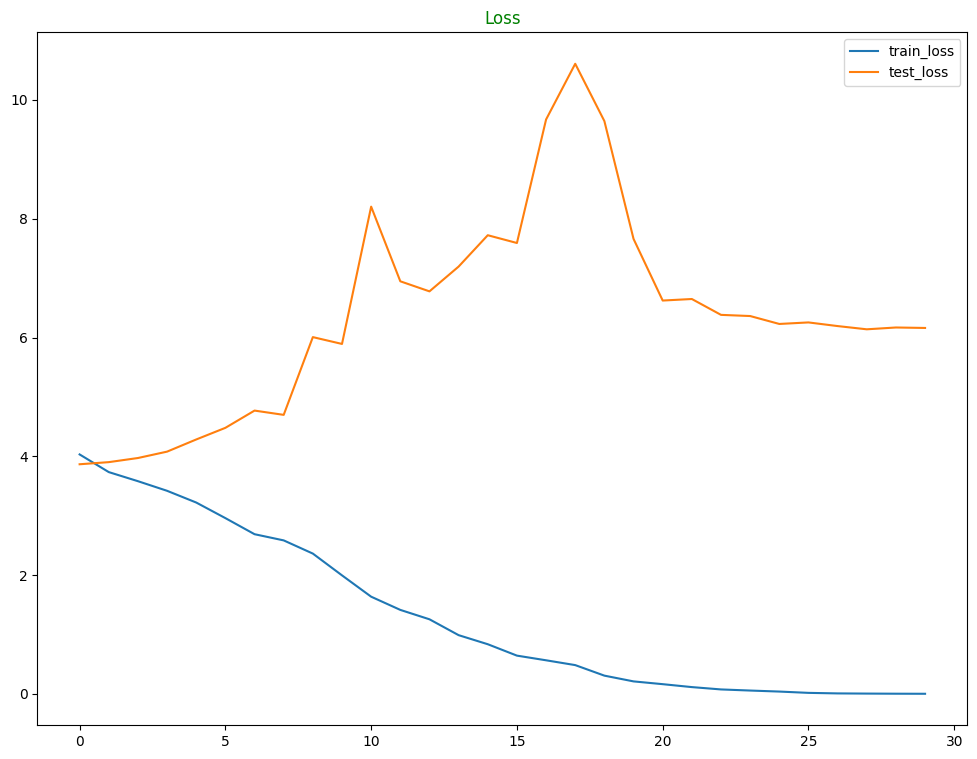

In [104]:
my_losses= hist(losses)
my_test_losses= hist(val_losses)
Epochs = [i for i in range(epochs)]
plt.figure(figsize=(12,9))
plt.title("Loss",color='green')
plt.plot(Epochs,my_losses)
plt.plot(Epochs,my_test_losses)
plt.legend(['train_loss','test_loss'],loc="best")
plt.show()

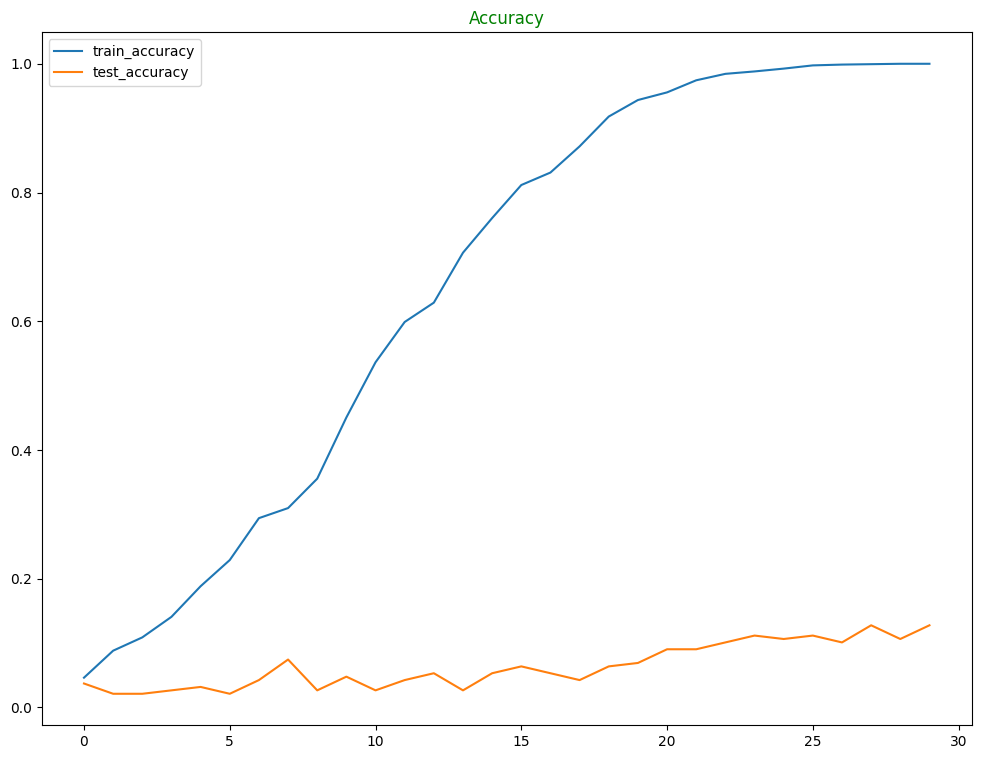

In [105]:
my_accuracies= hist(accuracies)
my_test_accuracies= hist(val_accuracies)
Epochs = [i for i in range(epochs)]
plt.figure(figsize=(12,9))
plt.title("Accuracy",color='green')
plt.plot(Epochs,my_accuracies)
plt.plot(Epochs,my_test_accuracies)
plt.legend(['train_accuracy','test_accuracy'],loc="best")
plt.show()

In [106]:
predictions = densenet_model.predict(valid_ds)
preds =[]
for i in predictions:
  preds.append(np.argmax(i))

3/3 [==============================] - 2s 63ms/step


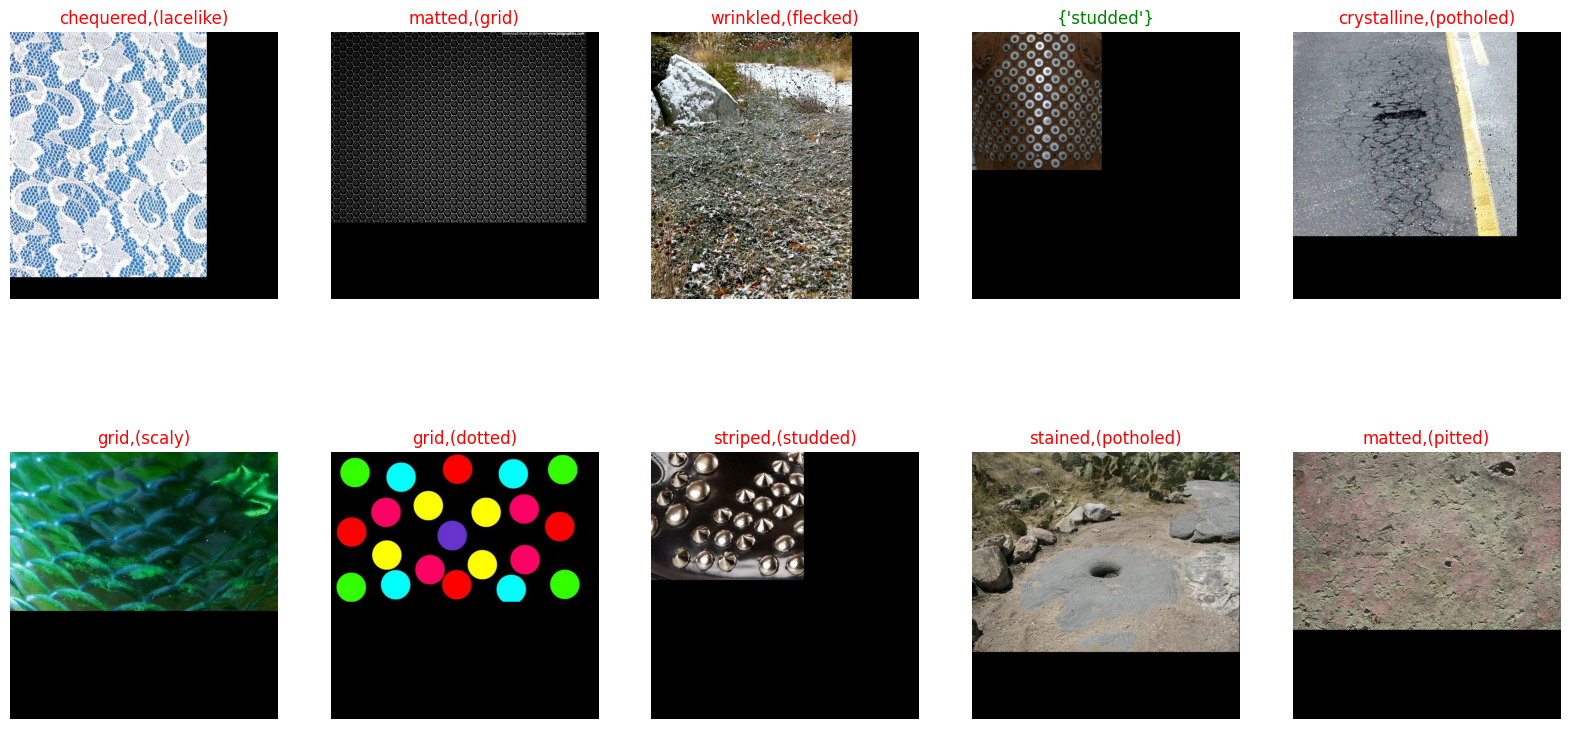

In [107]:
plt.figure(figsize=(20,10))
import random
randomly=[1,11,21,42,85,12,45,8,41,31]
for i in range(len(randomly)):
  ax = plt.subplot(2,5,i+1)
  image = validation['image'][i]
  plt.imshow(image)
  if labels[validation['label'][i]]==labels[preds[i]]:
    plt.title({labels[preds[i]]},color='green')
  else:
    plt.title(f"{labels[preds[i]]},({labels[validation['label'][i]]})",color='red')
  plt.axis("off")
plt.show()

In [108]:
json_model = densenet_model.to_json()
with open("densenet_model.json", "w") as json_file:
    json_file.write(json_model)